# 03b - Vertex AI + BQML - Online Predictions with BQML Models

* Models built with BigQuery ML (BQML), like the one in (03a), can also be exported for use and deployment outside of BigQuery. 
* A Vertex AI Endpoint can be used for online predictions with an exported model. This demonstration shows the process of exporting and deploying a BQML model with Vertex AI.



----
## Prerequisites:
* 03a - BigQuery Machine Learning (BQML) - Machine Learning with SQL
----
## Overview:
* Export the BigQuery ML model built in (03a) to a GCS bucket URI
    * EXPORT MODEL …
* Use Python Client google.cloud.aiplatform for Vertex AI
    * Upload Model
        * Model - aiplatform.Model.upoad
    * Create Endpoint
        * Endpoint - aiplatform.Endpoint.create
    * Deploy to Endpoint
        * Endpoint.deploy(model=Model)
    * Online Predictions
        * Endpoint.predict


----
## Set up

Input

In [3]:
REGION = 'us-central1'
PROJECT_ID='nguyen-demo5'
DATANAME = 'taxi'
NOTEBOOK = '03b'

# Resources
DEPLOY_IMAGE='us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest'
DEPLOY_COMPUTE = 'n1-standard-4'

# Model Training
VAR_TARGET = 'tips_label'
#  Based on the best result among the models, we selected the logistic regression model VERSION 4: taxi_lr_v4 for our online prediction.
VAR_OMIT= 'unique_key taxi_id trip_start_timestamp trip_end_timestamp trip_miles pickup_census_tract dropoff_census_tract pickup_community_area dropoff_community_area tips extras trip_total pickup_latitude pickup_longitude dropoff_latitude dropoff_longitude' # add more variables to the string with space delimiters

Packages:

In [4]:
from google.cloud import aiplatform
from datetime import datetime

from google.cloud import bigquery
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np

Clients:

In [6]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bigquery = bigquery.Client()

Parameters:

In [7]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{DATANAME}/models/{NOTEBOOK}"
params = {"URI": URI}
DIR = f"temp/{NOTEBOOK}"

Enviroments:

In [9]:
!rm -rf {DIR}
!mkdir -p {DIR}

----
## Export the BigQuery Model
Export the BigQuery Model:

In [10]:
export = bigquery.query(query = f"EXPORT MODEL {DATANAME}.{DATANAME}_lr_v4 OPTIONS(URI = '{URI}')")

In [11]:
export.result()

### New exported Model inside the bucket
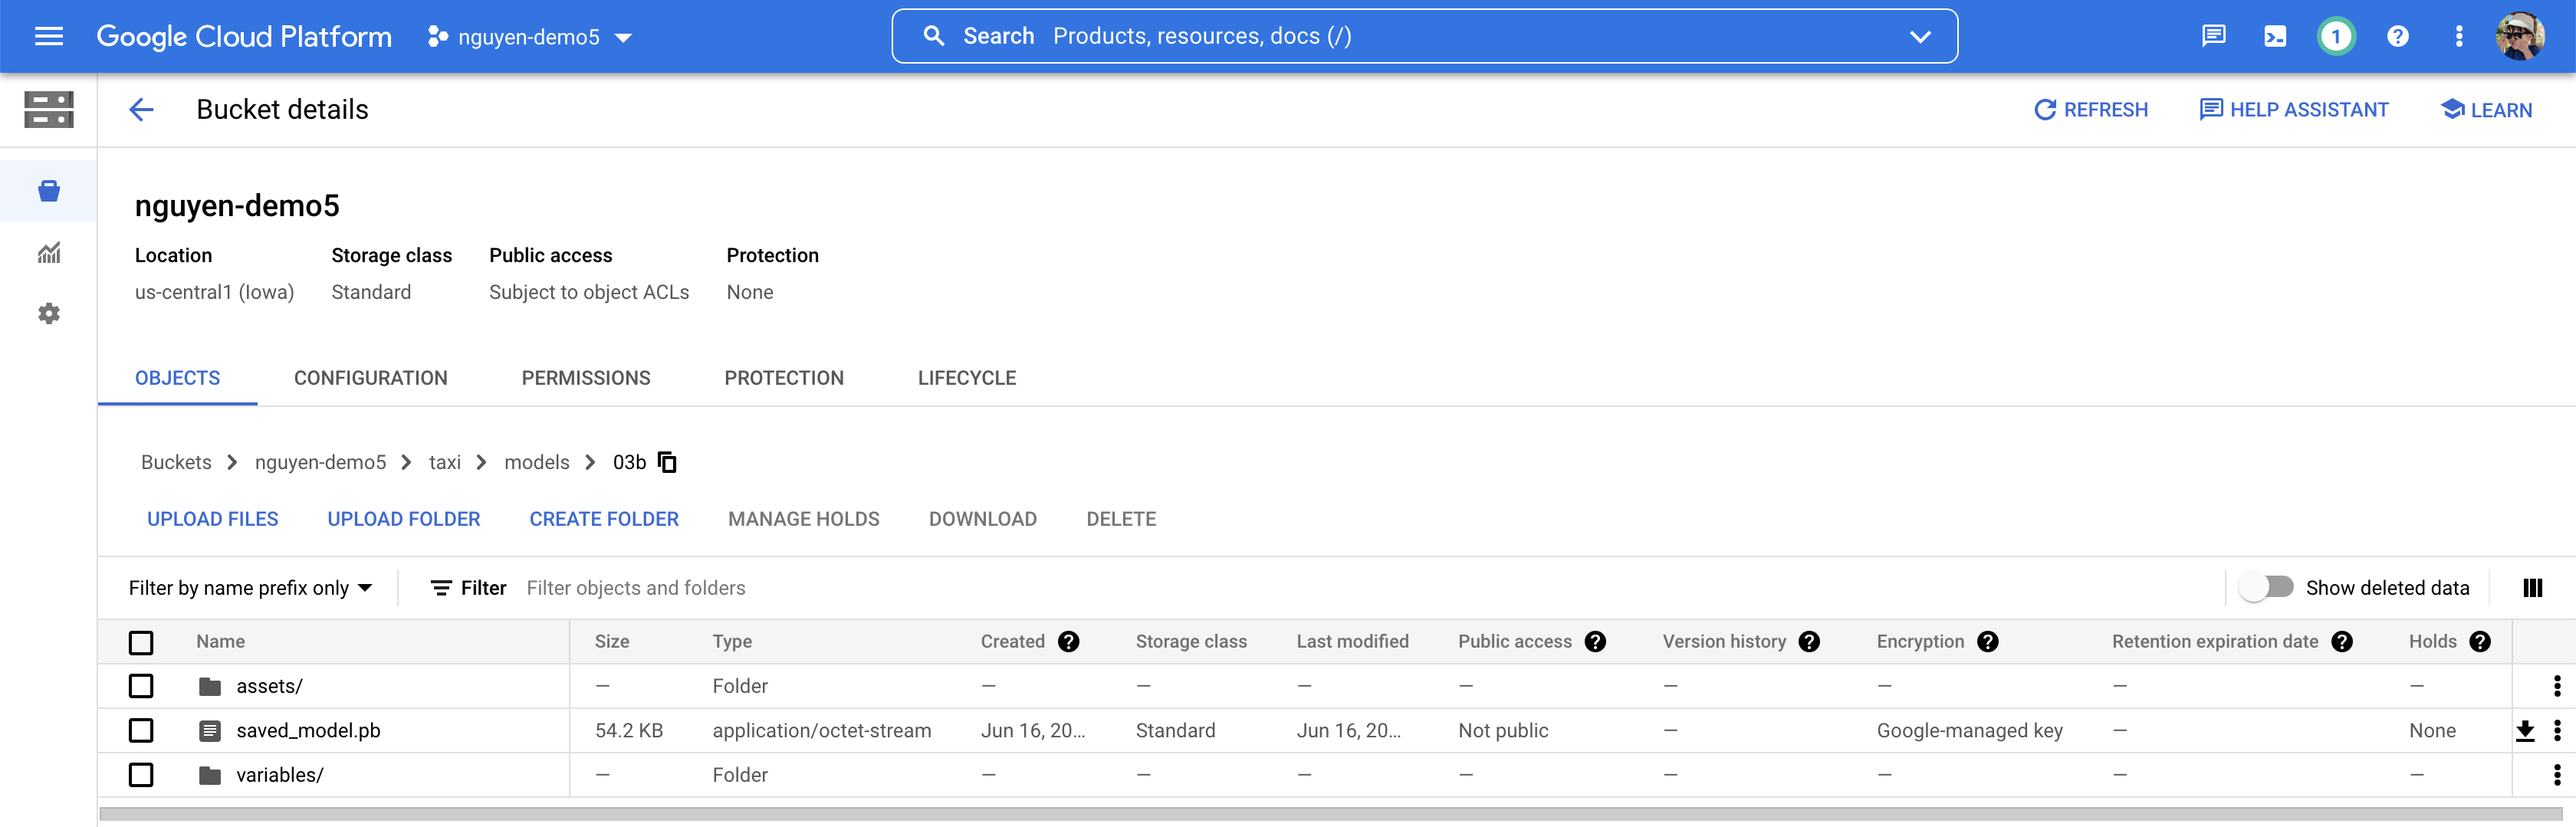


----
## Serving
### Upload The Model

In [13]:
model = aiplatform.Model.upload(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    serving_container_image_uri = DEPLOY_IMAGE,
    artifact_uri = URI,
    labels = {'notebook':f'{NOTEBOOK}'}
)

Creating Model
Create Model backing LRO: projects/716133108361/locations/us-central1/models/8786228203883593728/operations/4593756900788535296
Model created. Resource name: projects/716133108361/locations/us-central1/models/8786228203883593728
To use this Model in another session:
model = aiplatform.Model('projects/716133108361/locations/us-central1/models/8786228203883593728')


In [14]:
model.display_name

'03b_taxi_20220616195943'

#### Newly model was uploaded to VertexAI Models from bucket.
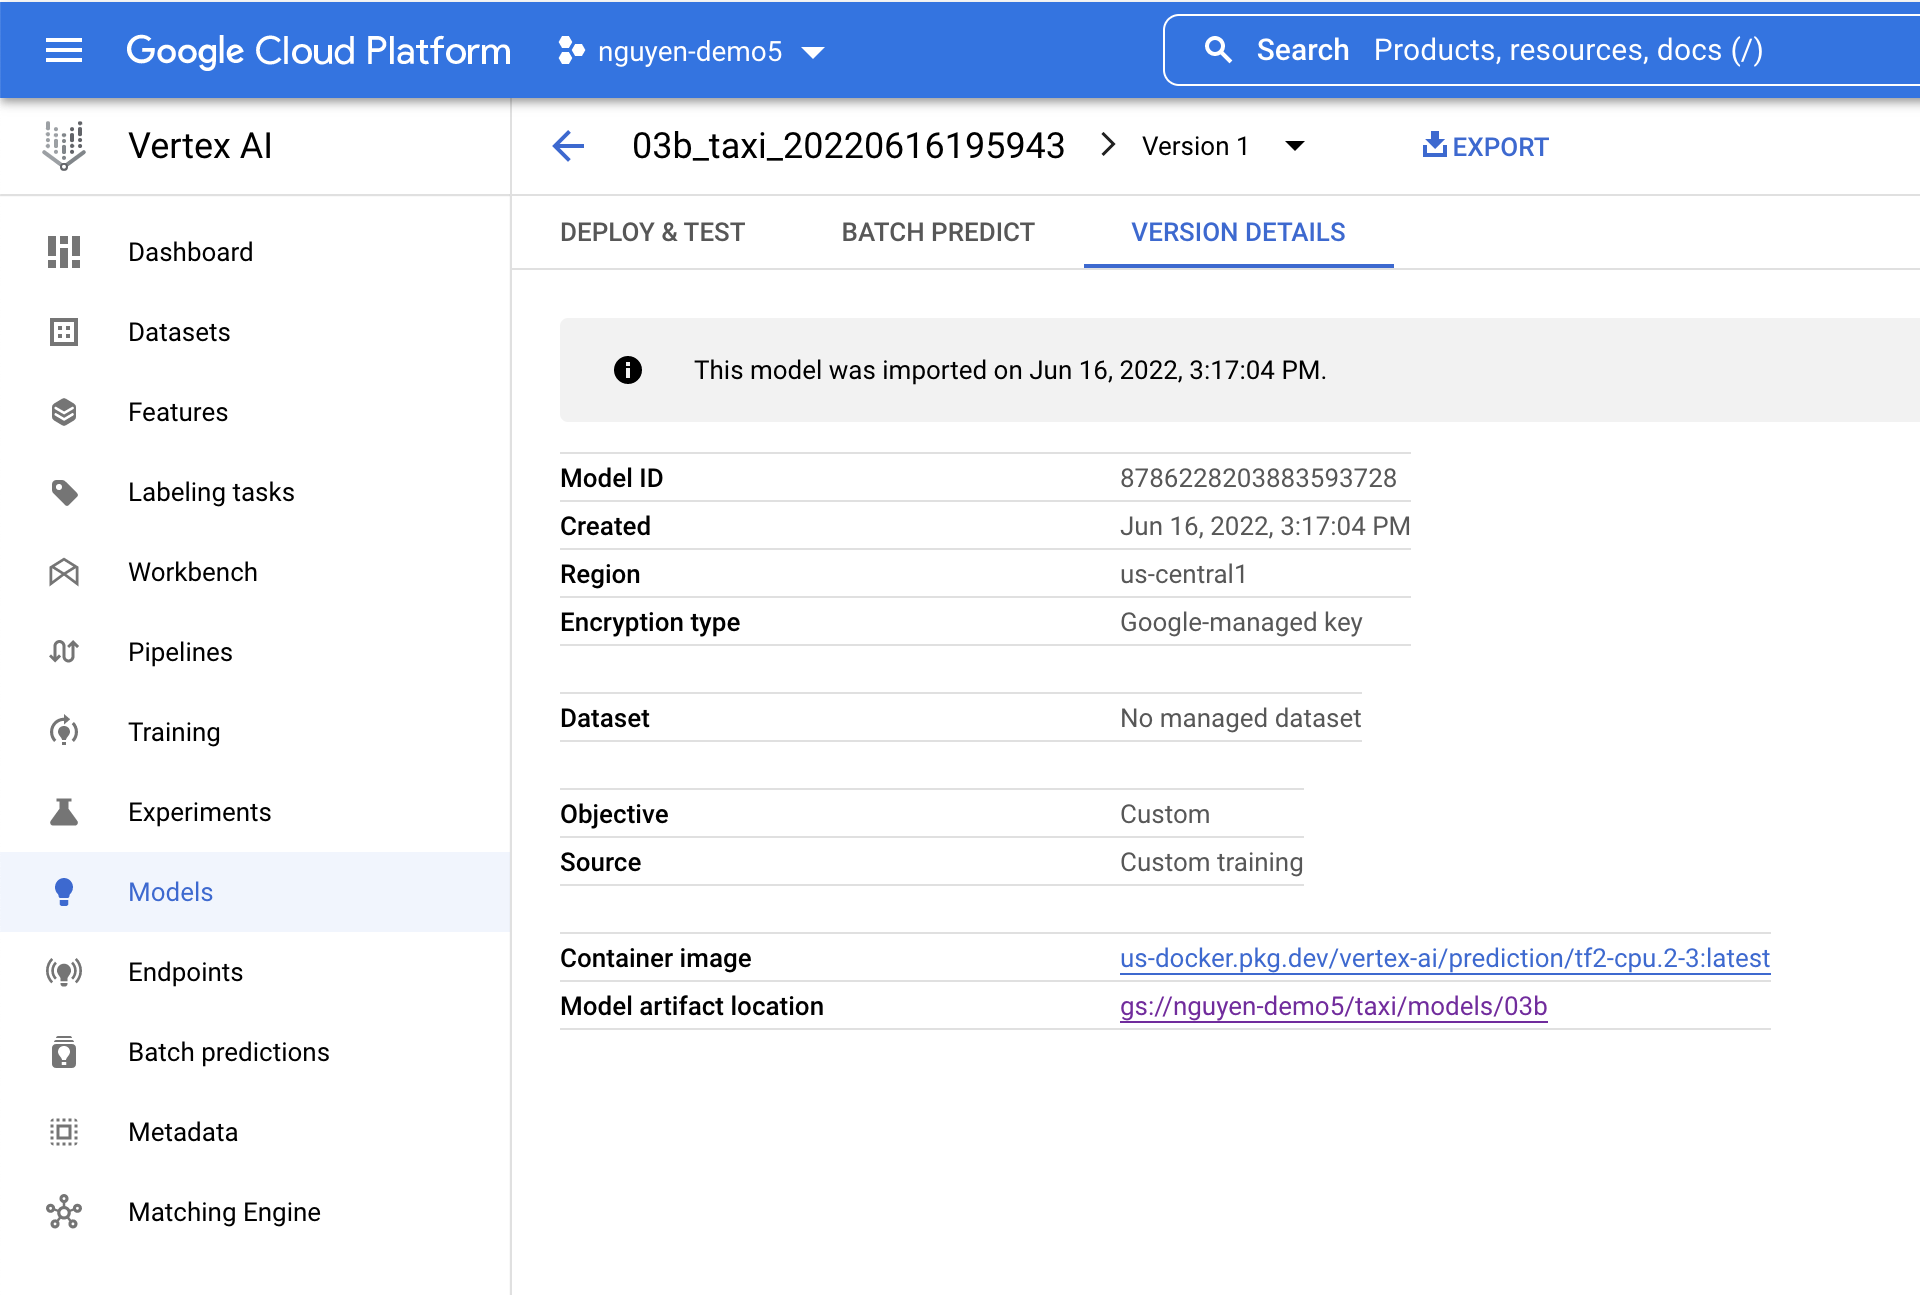


### Create An Endpoint

In [16]:
endpoint = aiplatform.Endpoint.create(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    labels = {'notebook':f'{NOTEBOOK}'}
)

Creating Endpoint
Create Endpoint backing LRO: projects/716133108361/locations/us-central1/endpoints/2727941125070389248/operations/8178622204175450112
Endpoint created. Resource name: projects/716133108361/locations/us-central1/endpoints/2727941125070389248
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/716133108361/locations/us-central1/endpoints/2727941125070389248')


In [17]:
endpoint.display_name

'03b_taxi_20220616195943'

#### New endpoint was created inside VertexAI Endpoints
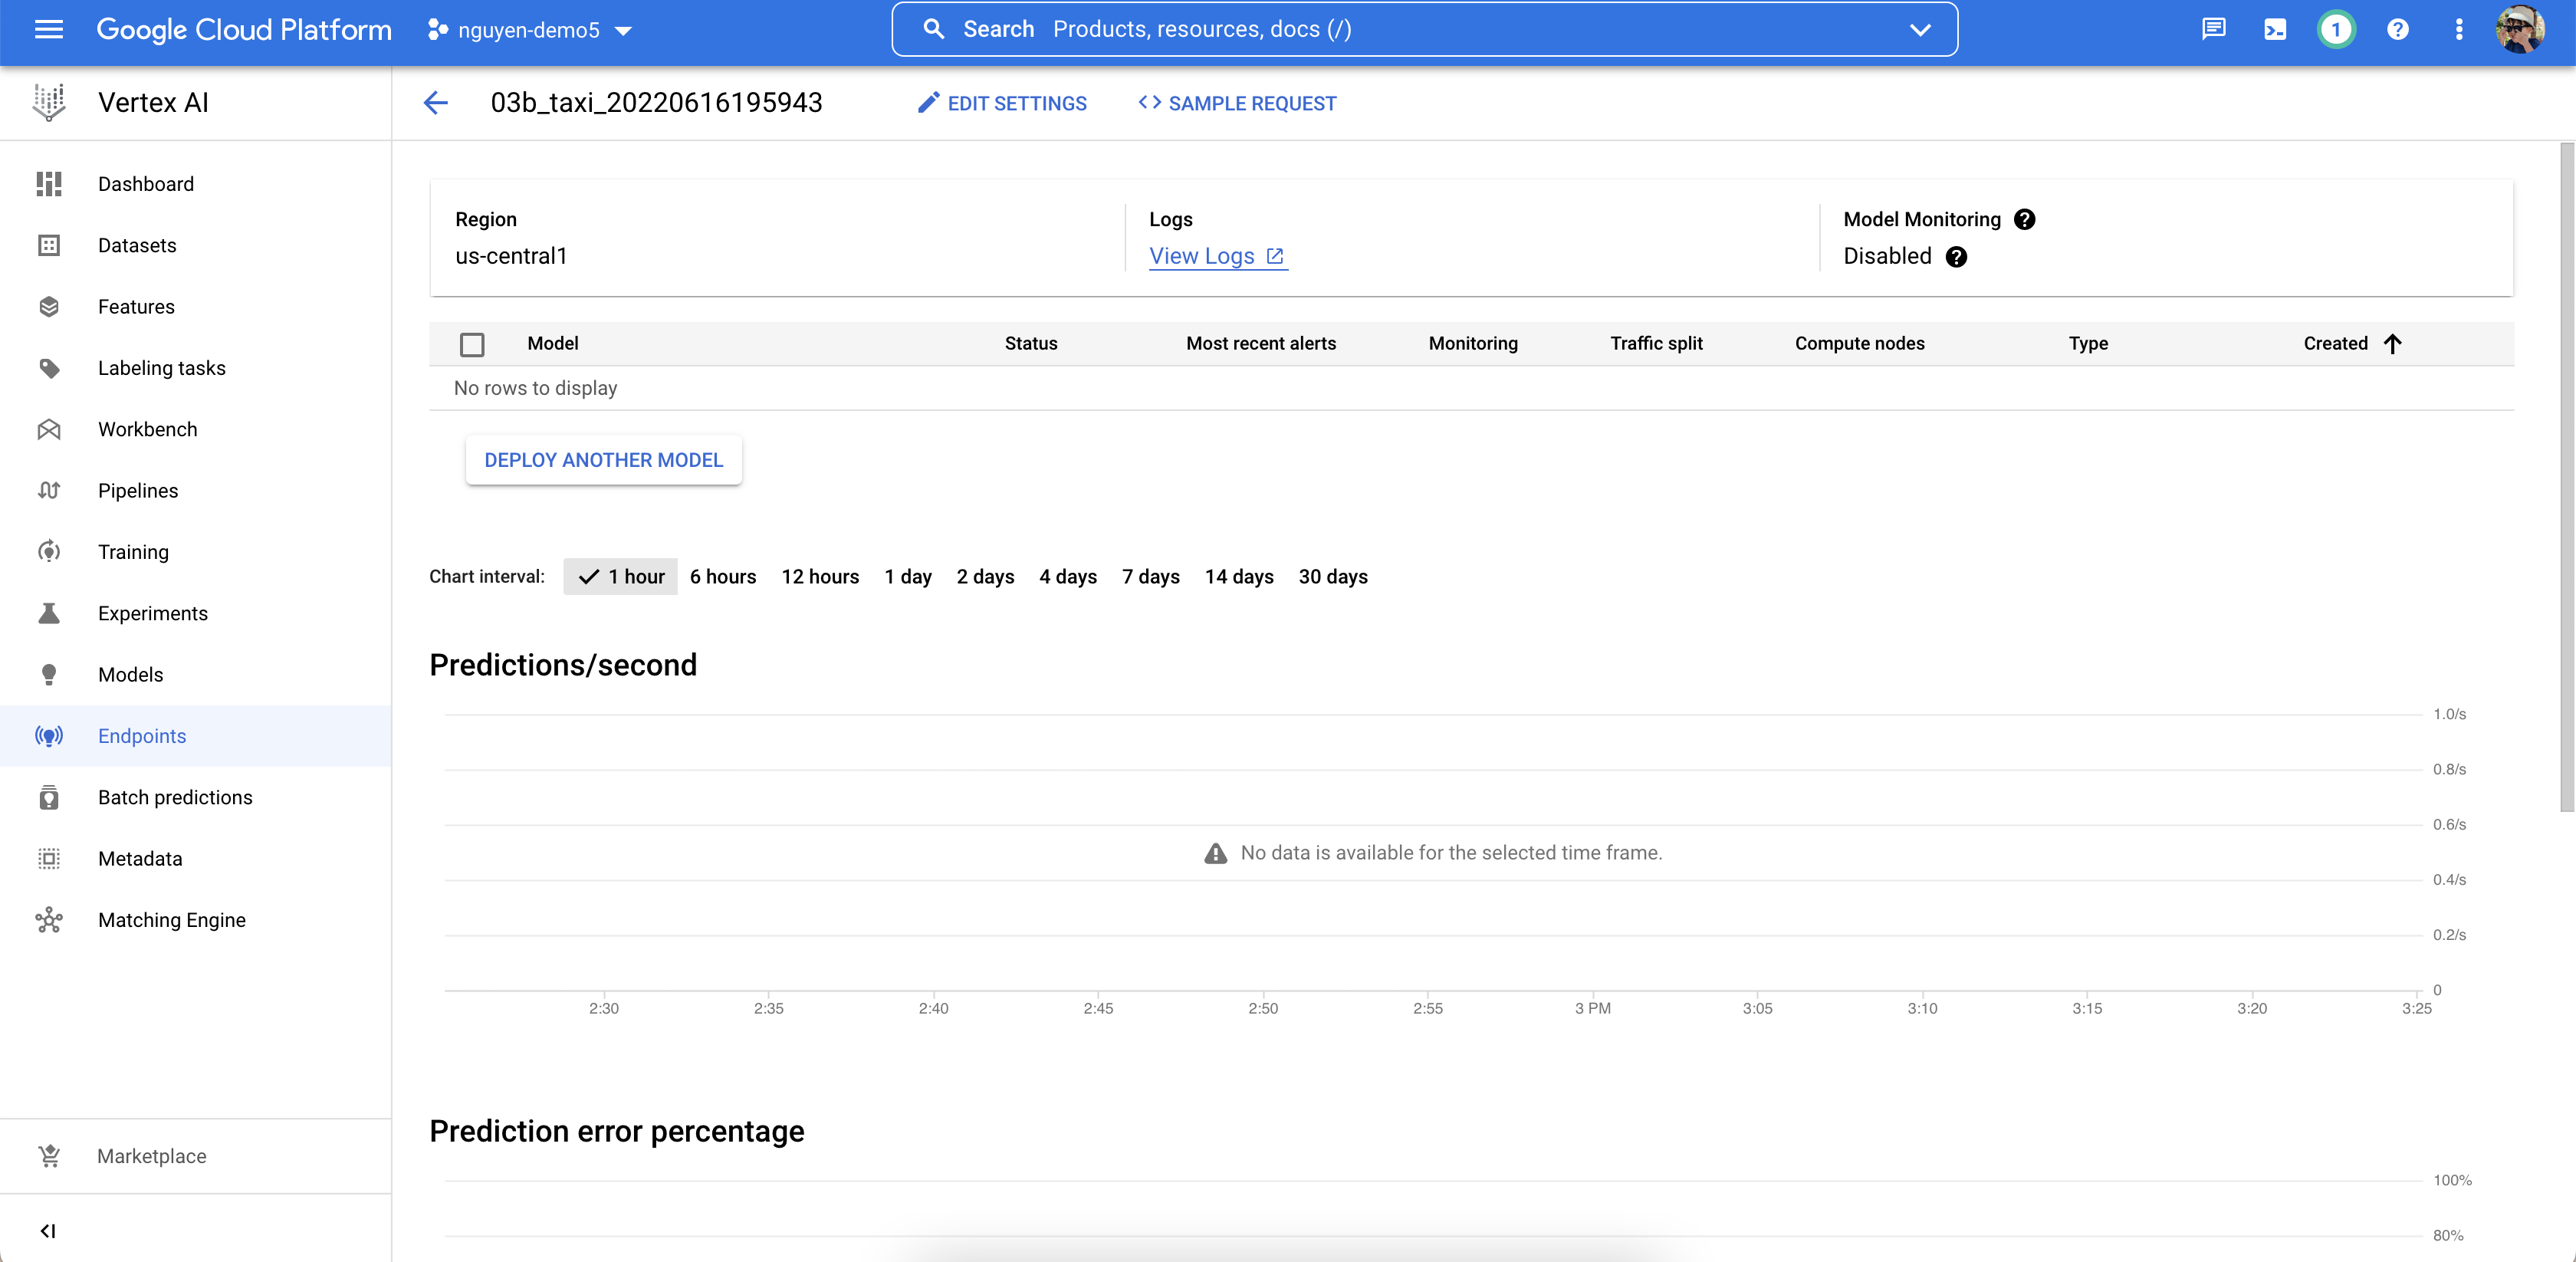



### Deploy Model To Endpoint

In [18]:
endpoint.deploy(
    model = model,
    deployed_model_display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    traffic_percentage = 100,
    machine_type = DEPLOY_COMPUTE,
    min_replica_count = 1,
    max_replica_count = 1
)

Deploying Model projects/716133108361/locations/us-central1/models/8786228203883593728 to Endpoint : projects/716133108361/locations/us-central1/endpoints/2727941125070389248
Deploy Endpoint model backing LRO: projects/716133108361/locations/us-central1/endpoints/2727941125070389248/operations/3882188159663996928
Endpoint model deployed. Resource name: projects/716133108361/locations/us-central1/endpoints/2727941125070389248


#### Deployed model inside VertexAI Endpoints
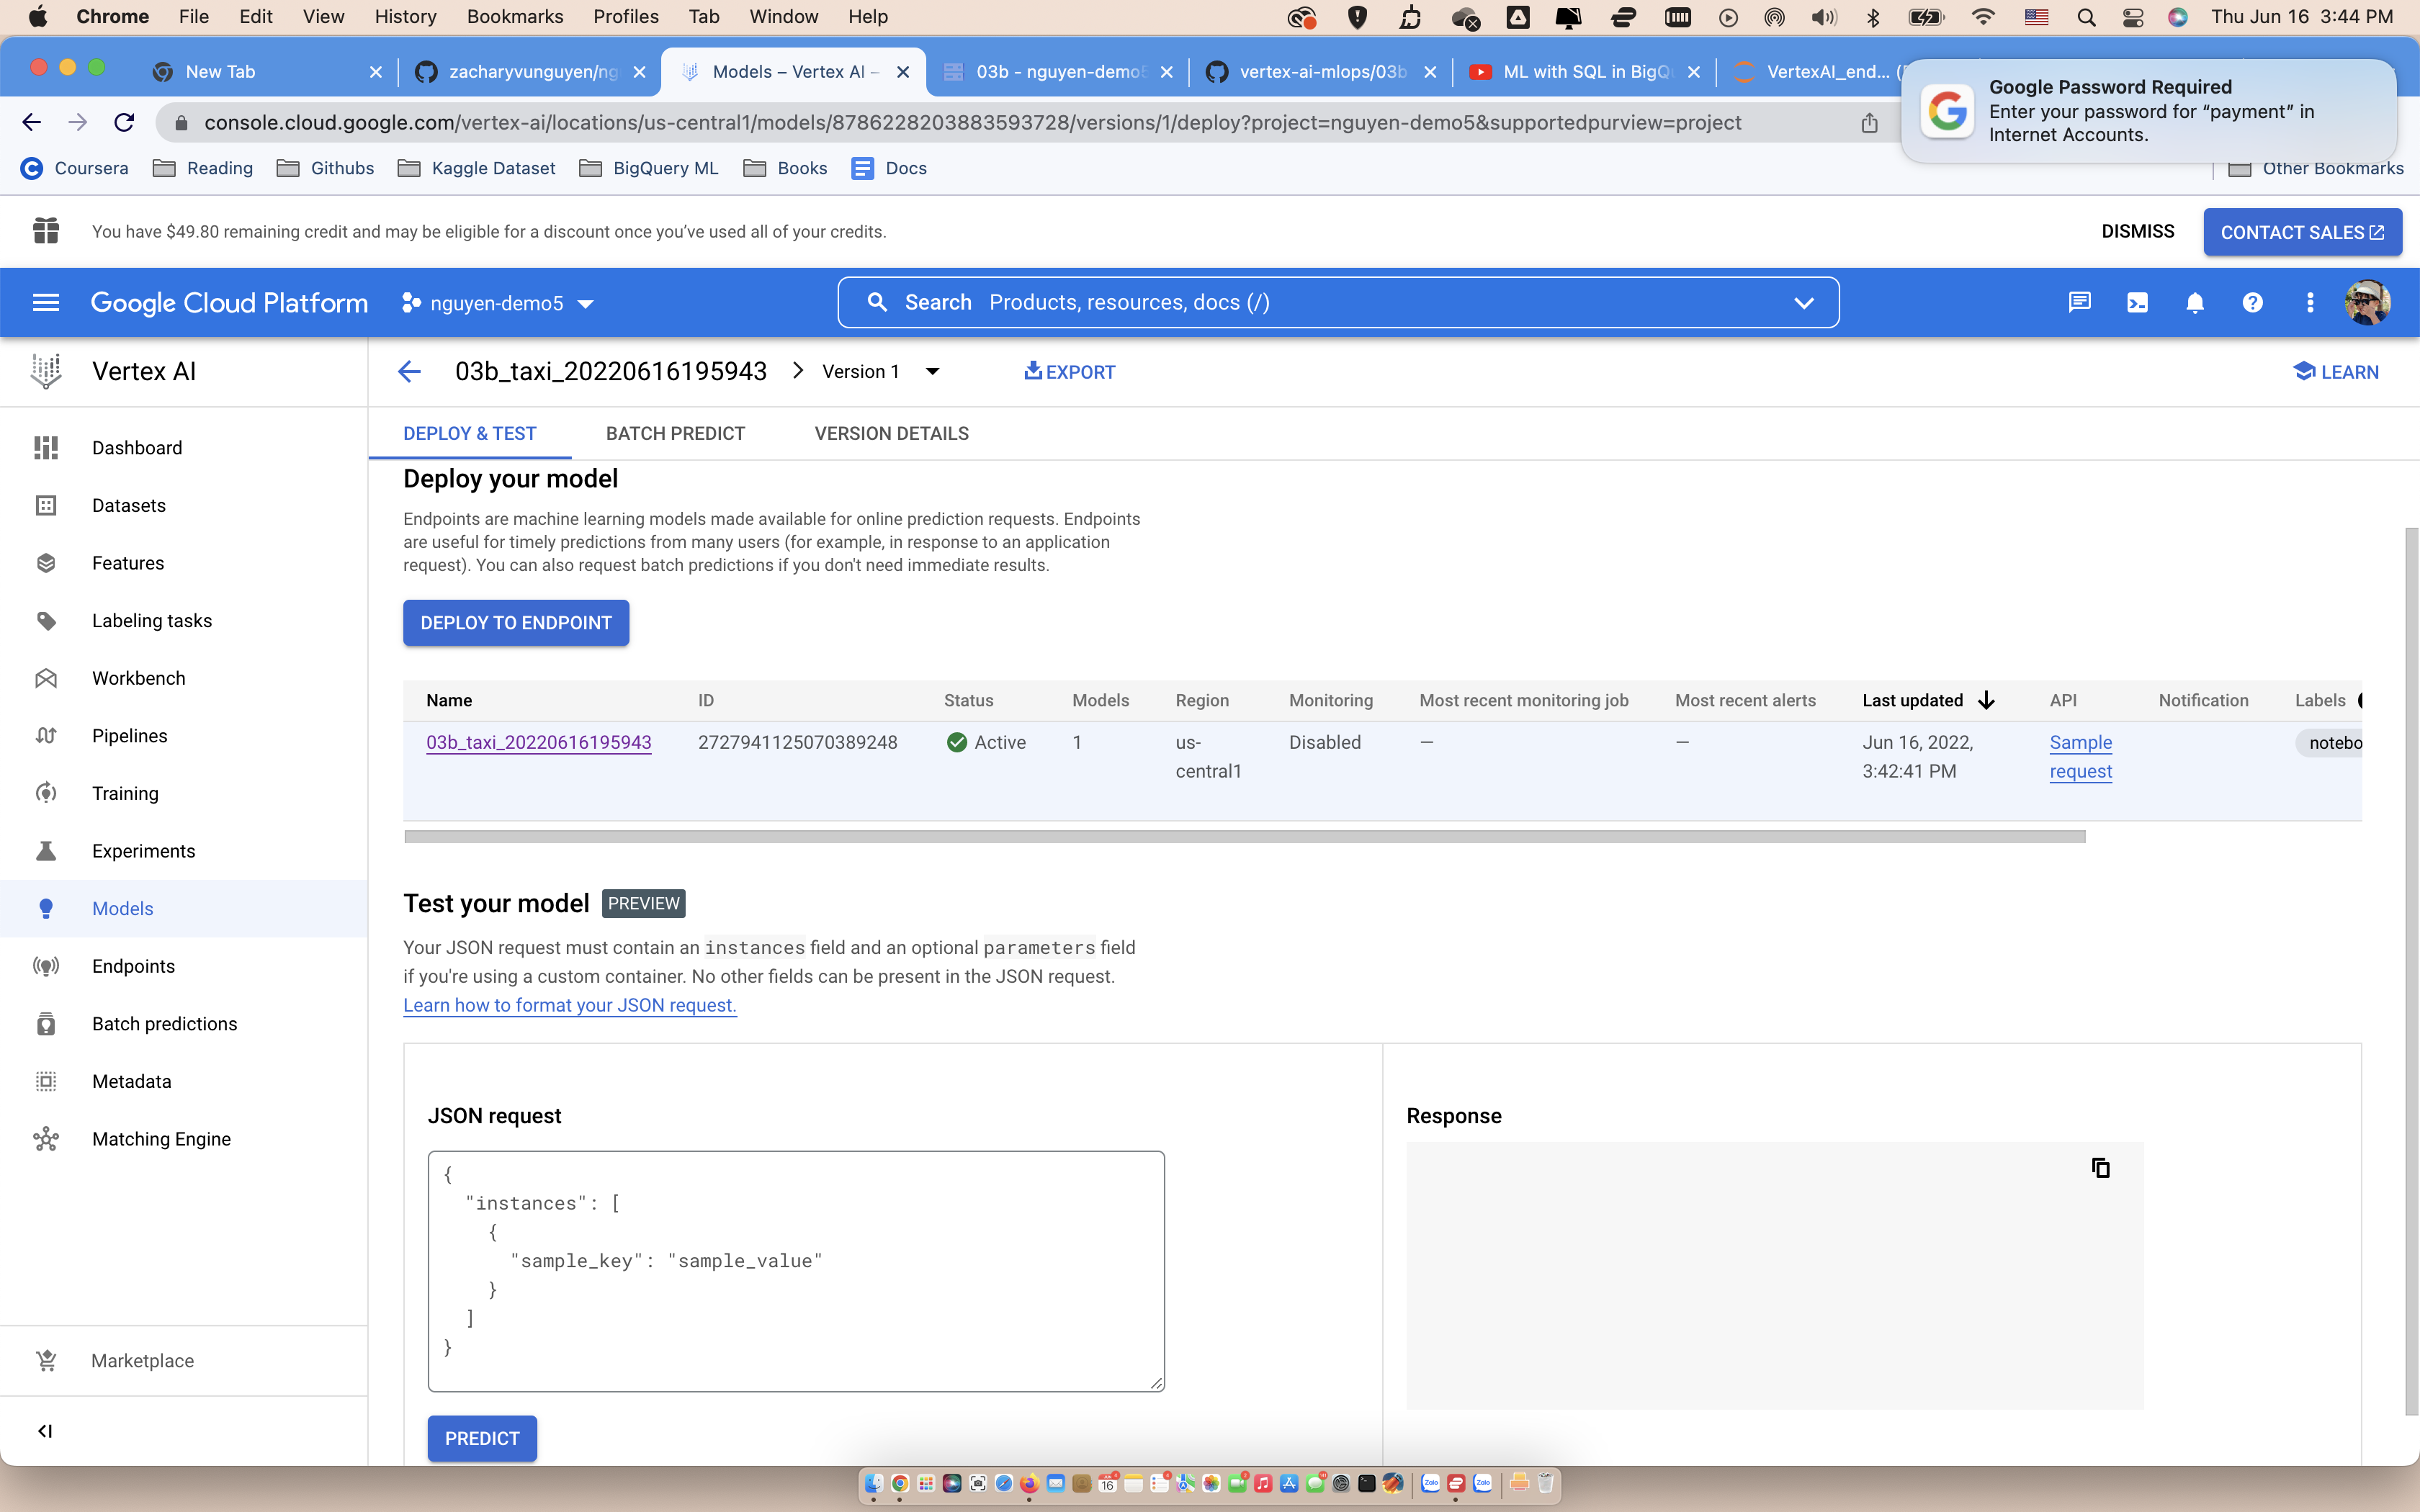

----
## Prediction
### Prepare a record for prediction: instance and parameters lists

In [30]:
pred = bigquery.query(query = f"SELECT * FROM {DATANAME}.{DATANAME}_prepped WHERE splits='TEST' and tips_label = 'YES'LIMIT 10").to_dataframe()

In [31]:
pred.head(4)

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,splits,tips_label
0,27e9197a84622070ba71295eb097ebebc13c3fd1,b'w\xc77y\xcd\xb7\xdb\xde\x1e\xd9\xff4\xdfn\xb...,2019-10-09 14:45:00+00:00,2019-10-09 15:15:00+00:00,1840,4.49,NaN,NaN,14,3,...,Credit Card,Flash Cab,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.96581197,-87.655878786,POINT (-87.6558787862 41.96581197),TEST,YES
1,91da935b7144323d78953de21d19be838f297370,b's\x9f\x1ak\xbd\x1bi\xbd}u\xe7\x1b\xe7N\xfbs\...,2019-10-26 06:15:00+00:00,2019-10-26 06:30:00+00:00,1108,9.22,NaN,NaN,14,8,...,Credit Card,Chicago Carriage Cab Corp,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.899602111,-87.633308037,POINT (-87.6333080367 41.899602111),TEST,YES
2,3fd8ef55865a59c799bb6f04cbbf9b6a13d26d81,b'\xe3\xae8\xef\x97^s\xd7\x1f\xebGyq\xf7=\xf3\...,2019-10-26 05:00:00+00:00,2019-10-26 05:15:00+00:00,818,8.54,NaN,NaN,14,8,...,Credit Card,Chicago Carriage Cab Corp,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.899602111,-87.633308037,POINT (-87.6333080367 41.899602111),TEST,YES
3,5cd6ef703c786d3e87a6594a993a1c2afcf3bf38,b'{N\x1a\xd3G:m\xfdu\xe7\x9e\xb4\xdfM\xb8\xf5\...,2019-10-19 04:45:00+00:00,2019-10-19 05:00:00+00:00,840,8.90,NaN,NaN,14,8,...,Credit Card,Taxi Affiliation Services,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.899602111,-87.633308037,POINT (-87.6333080367 41.899602111),TEST,YES


In [32]:
newob = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET,'splits'])]].to_dict(orient='records')[0]
newob

{'trip_seconds': 1840,
 'fare': 17.5,
 'tolls': 0.0,
 'payment_type': 'Credit Card',
 'company': 'Flash Cab',
 'pickup_location': 'POINT (-87.7215590627 41.968069)',
 'dropoff_location': 'POINT (-87.6558787862 41.96581197)'}

In [33]:
instances = [json_format.ParseDict(newob, Value())]
parameters = json_format.ParseDict({}, Value())

In [34]:
#instances

In [35]:
#parameters

### Get Predictions: Python Client

In [36]:
prediction = endpoint.predict(instances=instances, parameters=parameters)
prediction

Prediction(predictions=[{'tips_label_probs': [0.8716292834555592, 0.1283707165444408], 'predicted_tips_label': ['YES'], 'tips_label_values': ['YES', 'NO']}], deployed_model_id='5544779964269723648', explanations=None)

In [37]:
prediction.predictions[0]#['classes'][np.argmax(prediction.predictions[0]['scores'])]

{'tips_label_probs': [0.8716292834555592, 0.1283707165444408],
 'predicted_tips_label': ['YES'],
 'tips_label_values': ['YES', 'NO']}

In [38]:
prediction.predictions[0][f'{VAR_TARGET}_values'][np.argmax(prediction.predictions[0][f'{VAR_TARGET}_probs'])]

'YES'

### Get Predictions: REST

In [39]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": [newob]}))

#### New `request.json` file was created insde the temp folder
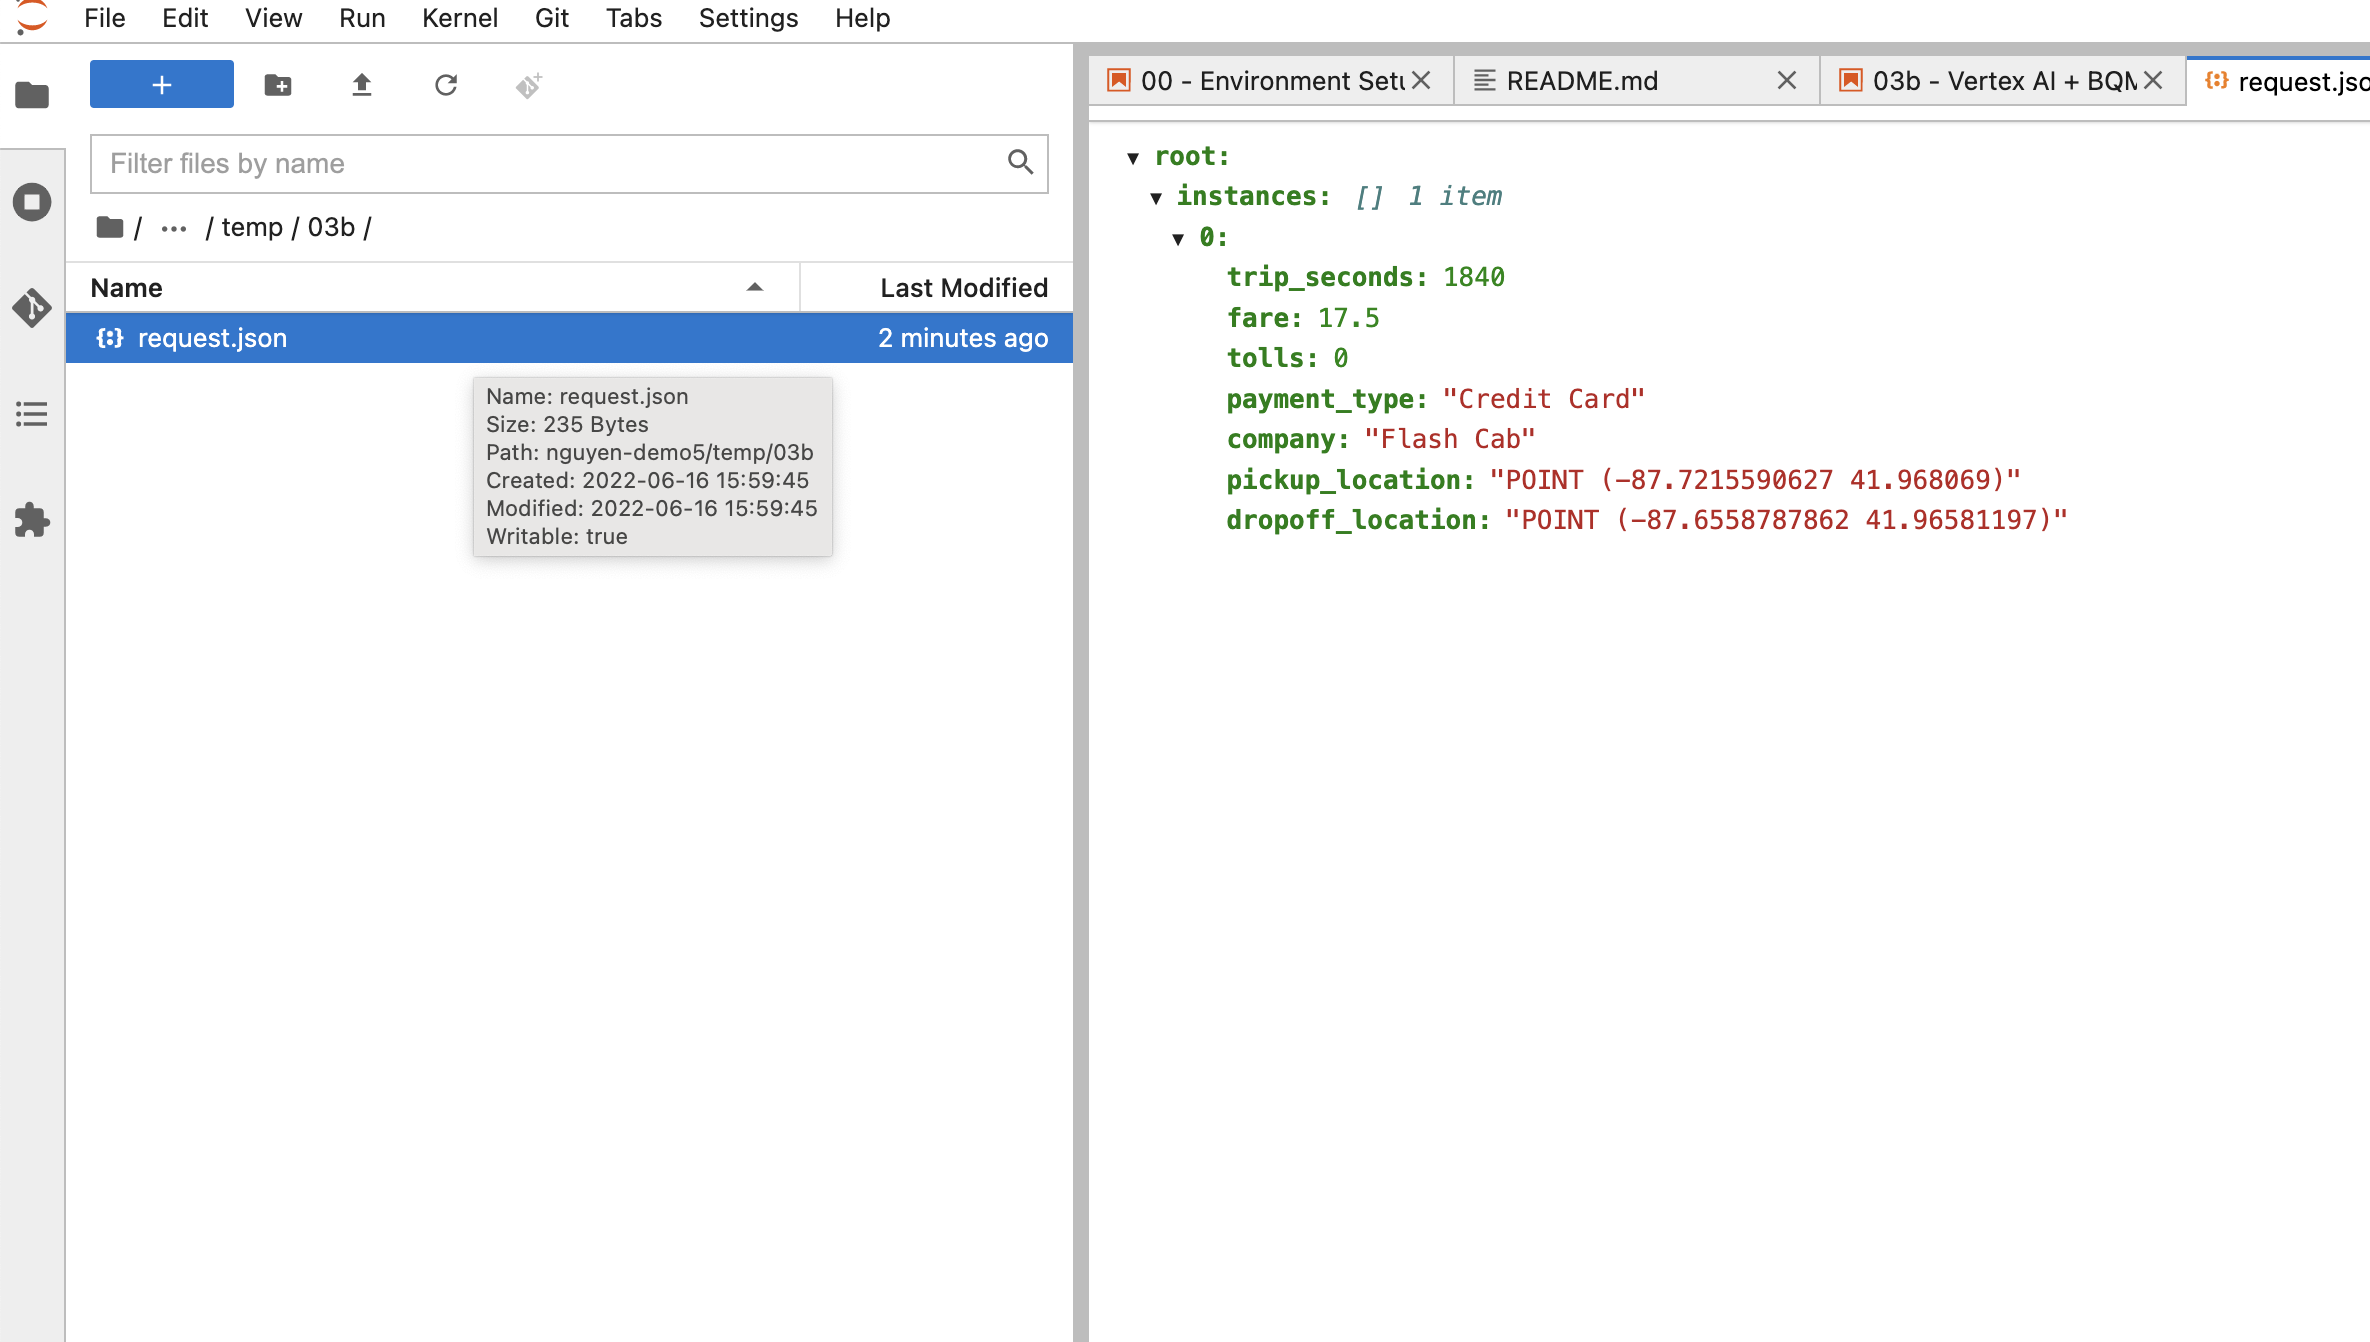

In [40]:
!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

{
  "predictions": [
    {
      "predicted_tips_label": [
        "YES"
      ],
      "tips_label_probs": [
        0.87162928345555923,
        0.12837071654444079
      ],
      "tips_label_values": [
        "YES",
        "NO"
      ]
    }
  ],
  "deployedModelId": "5544779964269723648",
  "model": "projects/716133108361/locations/us-central1/models/8786228203883593728",
  "modelDisplayName": "03b_taxi_20220616195943"
}


### Get Predictions: gcloud (CLI)

In [41]:
!gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json

Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[{'predicted_tips_label': ['YES'], 'tips_label_probs': [0.8716292834555592, 0.1283707165444408], 'tips_label_values': ['YES', 'NO']}]
